In [3]:
import logging
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import math
import pandas as pd
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch
import torch.nn as nn
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import pickle
from tqdm import tqdm_notebook as tqdm
import torchvision
import time
from collections import defaultdict
from torch.nn import CTCLoss
from Levenshtein import distance
import random
from torch.utils import data
from torch.utils.data import DataLoader

In [4]:
class ImageDataset(data.Dataset):
    """
    Dataset class for handwritten lines.

    Parameters
    ----------
    pickle_file : str
        Path to a dataset pickle file.
    meta : bool
        If True, meta data about files is provided.
    num_imgs : int, optional (default=-1)
        Choose only `num_imgs` imgs for processing. If set to -1, uses all available images.

    """

    def __init__(self, pickle_file, meta=False, num_imgs=-1):
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
        self.reference_dataset = dataset
        self.num_imgs = num_imgs
        if (self.num_imgs > 0) and (self.num_imgs < len(self.reference_dataset)):
            inds = np.random.choice(np.arange(len(self.reference_dataset)),
                                    self.num_imgs, replace=False)
            self.reference_dataset = [self.reference_dataset[i] for i in inds]
        self.meta = meta

    def __getitem__(self, idx):
        data = self.reference_dataset[idx]
        #img = cv2.imread(data['img_path'], cv2.IMREAD_UNCHANGED) / 255.
        img = cv2.resize(cv2.imread(data['img_path'], 0), (444,64)) / 255.
        img = torch.from_numpy(img).unsqueeze(0).float()
        text = data['description']
        width = data['width']
        height = data['height']

        if self.meta:
            return img, text, data, width, height
        else:
            return img, text

    def __len__(self):
        return len(self.reference_dataset)
    
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index
        #self.alphabet = alphabet

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
    
    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        """

        length = []
        result = []
        for item in text:            
#             item = item.decode('utf-8','strict')
            length.append(len(item))
            r = []
            for char in item:
                index = self.dict[char]
                # result.append(index)
                r.append(index)
            result.append(r)
        
        max_len = 0
        for r in result:
            if len(r) > max_len:
                max_len = len(r)
        
        result_temp = []
        for r in result:
            for i in range(max_len - len(r)):
                r.append(0)
            result_temp.append(r)

        text = result_temp
        return (torch.LongTensor(text), torch.LongTensor(length))


    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.LongTensor([l]), raw=raw))
                index += l
            return texts

In [3]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output
    
class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0, 0]
        ss = [1, 1, 1, 1, 1, 1, 1, 2]
        nm = [16, 32, 128, 256, 512, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        convRelu(7, True)
        

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)
        
        # add log_softmax to converge output
        output = F.log_softmax(output, dim=2)

        return output


    def backward_hook(self, module, grad_input, grad_output):
        for g in grad_input:
            g[g != g] = 0   # replace all nan/inf in gradients to zero

In [4]:
def train_on_batch_rec(images, gt_text, model_crnn, ocr_loss, optimizer, device, batch_size, converter):

    model_crnn.train()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    return (loss.item(), acc_char, acc_str, cer)

def val_on_batch_rec(images, gt_text, model_crnn, ocr_loss, device, batch_size, converter):

    model_crnn.eval()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    _, preds = pred_text.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    raw_preds = converter.decode(preds.data, preds_size, raw=True)
    
    return (loss.item(), acc_char, acc_str, cer, decode_text[:5], gt_text[:5], raw_preds[:5])

In [15]:
pickle_path_train = '/home/storage/3020/KrivorotovI/db/HKR/datasets/train.pkl'
pickle_path_val = '/home/storage/3020/KrivorotovI/db/HKR/datasets/val.pkl'
with open(pickle_path_train, 'rb') as f:
    full_dataset = pickle.load(f)
alphabet = ''
st_len = []
for example in full_dataset:
    alphabet += example['description']
    st_len.append(len(example['description']))
alphabet = list(set(alphabet))
alphabet =''.join(alphabet)


In [16]:
max(st_len)

42

In [17]:
alphabet

'нЛШкВоеяГ–зЯЧЬвй!чөтх р?ьҚылИ,бфКНАюДЕ—;РЙш)HцпСЫБ.эсмӨиХЭПЖ-щ…:ЗуқгМТУЮдО(oаёж'

In [18]:
imgH = 32 # the height of the input image to network
imgW = 100 # the width of the input image to network
nh = 256 # size of the lstm hidden state
nc = 1
nclass = len(alphabet)+1
batch_size = 64

In [19]:
device = torch.device("cuda:6")
converter = strLabelConverter(alphabet)
net = CRNN(imgH, nc, nclass, nh)
net.to(device)
ocr_loss = CTCLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.0001)
train_dataset = ImageDataset(pickle_path_train, num_imgs=-1)
val_dataset = ImageDataset(pickle_path_val, num_imgs=-1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)

torch.Size([64, 1, 64, 444])
во все концы


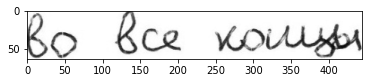

In [20]:
for imgs, text in train_dataloader:
    print(imgs.shape)
    plt.imshow(imgs[0][0], cmap = 'gray')
    print(text[0])
    break

In [21]:
ep = 100

train_loss = []
train_acc_char = []
train_acc_str = []
train_cer = []

val_loss = []
val_acc_char = []
val_acc_str = []
val_cer = []

best_str_acc = 0

for epoch in range(ep):
    train_epoch_loss = []
    
    train_epoch_acc_char = []
    train_epoch_acc_str = []
    train_epoch_cer = []
    
    with tqdm(total = len(train_dataloader), ncols='100%') as bar_train:
        for i, (images, gt_text) in enumerate(train_dataloader):

            results = train_on_batch_rec(images, gt_text, net, ocr_loss, optimizer, device, batch_size, converter)
            loss, acc_char, acc_str, cer = results
            
            train_epoch_loss.append(loss)
            train_epoch_acc_char.append(acc_char)
            train_epoch_acc_str.append(acc_str)
            train_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Train loss: {np.mean(train_epoch_loss):.4f}.\
            Acc char: {np.mean(train_epoch_acc_char):.4f}.\
            Acc str: {np.mean(train_epoch_acc_str):.4f}.\
            CER: {np.mean(train_epoch_cer):.4f}."
            bar_train.set_description(printed_data)
            bar_train.update(1)
            
    train_loss.append(np.mean(train_epoch_loss))
    
    train_acc_char.append(np.mean(train_epoch_acc_char))
    train_acc_str.append(np.mean(train_epoch_acc_str))
    train_cer.append(np.mean(train_epoch_cer))
    
    
    val_epoch_loss = []
    
    val_epoch_acc_char = []
    val_epoch_acc_str = []
    val_epoch_cer = []
    
    with tqdm(total = len(val_dataloader), ncols='100%') as bar_val:
        for i, (images, gt_text) in enumerate(val_dataloader):

            results = val_on_batch_rec(images, gt_text, net, ocr_loss, device, batch_size, converter)
            loss, acc_char, acc_str, cer, decode_text, gt_text, raw_preds = results
            
            val_epoch_loss.append(loss)
            val_epoch_acc_char.append(acc_char)
            val_epoch_acc_str.append(acc_str)
            val_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Val loss: {np.mean(val_epoch_loss):.4f}.\
            Acc char: {np.mean(val_epoch_acc_char):.4f}.\
            Acc str: {np.mean(val_epoch_acc_str):.4f}.\
            CER: {np.mean(val_epoch_cer):.4f}."
            bar_val.set_description(printed_data)
            bar_val.update(1)
        
    val_loss.append(np.mean(val_epoch_loss))
    
    val_acc_char.append(np.mean(val_epoch_acc_char))
    val_acc_str.append(np.mean(val_epoch_acc_str))
    val_cer.append(np.mean(val_epoch_cer))
    
    print('Lr now:', optimizer.param_groups[0]['lr'])

    for raw_pred, pred, gt in zip(raw_preds, decode_text, gt_text):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt)) 
    
    if epoch == 40:
        for g in optimizer_rnn.param_groups:
            g['lr'] = g['lr']*0.1
        for g in optimizer_conv.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer_rnn.param_groups[0]['lr'])
        
    if epoch == 70:
        for g in optimizer_rnn.param_groups:
            g['lr'] = g['lr']*0.1
        for g in optimizer_conv.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer_rnn.param_groups[0]['lr'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Lr now: 0.0001
А-----------------------------------------------------, => А,                  , gt: Актобе              
К--------------------------------------в--------------, => Кв,                 , gt: мне снится плащ     
Т-----------------------------------------------------у => Ту                  , gt: Под скальпелем      
Т-----------------------------------------------------у => Ту                  , gt: ТАРАЗ               
К-----------------------------------------------------у => Ку                  , gt: Кокшетау            



Lr now: 0.0001
м--------й---л--ы---ее------  -о-------ии-----о--к---и- => мйлые оиоки         , gt: малые ошибки        
к--------к--------  -с------н--------в------------л---, => кк снвл,            , gt: как сеновал,        
А---------к---т------------ы----и---------к--а------я-- => Актыикая            , gt: Актюбинская         
И--------------и----------------------к-------а-------, => Иика,               , gt: Ишака,              
А-------Т--------------Ы----И---------С---К-----------Я => АТЫИСКЯ             , gt: АКТЮБИНСКАЯ         



Lr now: 0.0001
Р-------------О--------С----------------И-----------Я-- => РОСИЯ               , gt: РОССИЯ              
к-----а-----з---аа-----х-----сс---т-------аа----н------ => казахстан           , gt: казахстан           
Р-----------о------с---------с-------и------------я---- => Россия              , gt: Россия              
и-------  о-д-------м-------  п--р--о--п-у-ж---д-е-н--, => и одм пропужден,    , gt: и одним пробужден,  
к---о--тт-----о--р---о-юю--------  дд---а----н----о---, => которою дано,       , gt: которою дано,       



Lr now: 0.0001
С-----е---------е--н------------ш---и---м----е----я--и- => Сееншимеяи          , gt: Летят шмели         
З--а--х-а-д--н-о--х-----ааззаа---х-с-т--а--н-с-к-аа--я- => Захаднох-азахстанская, gt: Западно-Казахстанская
п--------о----л----с--------я-----нн----------ы-------- => полсяны             , gt: поляны              
п---о--ж-н---а----- х--о--зж---а-----л-е--н-----------, => пожна хозжален,     , gt: полно сожалении,    
А------х--------К--а----б------н-----а----к---сс-----яя => АхКабнакся          , gt: Актюбинская         



Lr now: 0.0001
П----о--ж----а---------  -х--оо-р---о--ш------а-----я-- => Пожа хорошая        , gt: Пока хорошая        
К-------------------а-----тг------и---н---д-с----а----- => Катгиндса           , gt: Киргизия            
И------- -б--уу-д--д--т------  --м---о--т---н----т---ь- => И буддт мотнть      , gt: И будут мстить      
К---а---з--ы----л--о--рр---дд--и----н----с--к--а-----я- => Казылординская      , gt: Кызылординская      
А---------------к-----к--------сс---------------------у => Акксу               , gt: Аксу                



Lr now: 0.0001
Ш--------------а------х------т-------ии---н----сс--к--- => Шахтинск            , gt: Шахтинск            
В-----о---зз---в---р----аа---т---------я-----с---ьь---- => Возвратясь          , gt: возвратясь          
Г----д-ее-----  -в--ы----л-----  п----о--ж------а--рр-- => Где выл пожар       , gt: Где выл пожар       
в-----о--л---н-----ы---------м------о--рр---е---й-----. => волныморей.         , gt: волны морей.        
Т----о----  с-ерр--д--ы---к--с--я-----  т---о--с-к--а-. => То сердыкся тоска.  , gt: То сердечная тоска..



Lr now: 0.0001
п--е-рр-е-з--в-а-л-е--н---н--ы-го---  т---и---п---я--я- => перезваленныго типяя, gt: перехваченного плыла
К---------------т----------о----------в-----------ь---- => Ктовь               , gt: Кровь               
д------ж-----------и--------г---и--------т------------! => джигит!             , gt: джигит!             
я--з--в--и---т--ее-лл-ь--н--ыы---м---- с-в--о--л--м---. => язвительным сволм.  , gt: язвительным своим.  
с---к---о--л-ь--н----у-е--------  о--------- -с-к------ => скольнуе о ск       , gt: смолкнул бы он.     



Lr now: 0.0001
д----------жж------и----------г---------т-------------у => джигту              , gt: джигиту             
б-ее--с-м--еер--т---н-ы--л--и---  сст---и-х--а--м--и--? => бесмертныли стихами?, gt: бессмертными стихами?
О-----н----и----,,,-    -т--о---м---к---а-----л-------- => Они, томкал         , gt: Они, толкаясь       
У-------з----б---е----к-----и----с---т-------а----н---- => Узбекистан          , gt: Узбекистан          
З------------------к-------о---------л----------------- => Зкол                , gt: Злые                



Lr now: 0.0001
К-----а---в---с--трр------н---у-------   -т---и------е- => Кавстрну тие        , gt: Навстречу мне       
и--------з-----г---н--------а-------н--------ь-----я--- => изгнанья            , gt: изгнанья            
р------------------------------о----------------------- => ро                  , gt: по                  
И--------------  -с----е------р-----д----------р---ее-- => И сердре            , gt: И сердце            
Б------а---л--е-к---о------- -е-----   -м----о--р----я- => Балеко е моря       , gt: Далеко с моря       



Lr now: 0.0001
к--------------о-------р----------о--------к----------- => корок               , gt: корок               
Т-----у--р---к----е---с---т---а----н---с---к---а-----я- => Туркестанская       , gt: Туркестанская       
В----и----д----  -п---о---сс-тт--а---х----л--о--г---о-- => Вид постахлого      , gt: Вид постоялого      
и--ггр----ы--  п---о-з--а---быы--в----  сс--в--о--и---. => игры позабыв свои.  , gt: игры позабыв свои,  
п----о---с--а-----м-----и------  -п---о--сс--------ы--- => посами посы         , gt: косами косцы        



Lr now: 0.0001
И------  -в-ссп--оо--м---н--ии---л---  -я---  т-е-б--я- => И вспомнил я тебя   , gt: И вспомнил я тебя   
т----------в--оо----й-----   о------л--нн----и-----йй-, => твой олний,         , gt: твой синий,         
Н-----ы----  -ж-----а----мм-----б-----к---оо---н---я--, => Ны жамбконя,        , gt: Не жалей коня,      
к-----------л---ее-----вв-----е----р---------а--------- => клевера             , gt: клевера.            
А----к----м-----о----лл--иии---н----сс--к----а----я---- => Акмолинская         , gt: Акмолинская         



Lr now: 0.0001
А-------------кк------тт-------------об---бб----а------ => Актобба             , gt: Актобе              
З----а-----г------л---я-------т----------уу----сс---ьь- => Заглятусь           , gt: Загляжусь           
и------   -в--о-рр---ч--а---,,-   с--о--с--а----л---ии- => и ворча, сосали     , gt: и ворча, сосали     
в------о--йй------   с-оо--в--е-рр----ш----ии----т----, => вой совершит,       , gt: свой совершит,      
Г----рр----у--сс-тт-----н------,,--    Н---ии---н----а- => Грустн, Нина        , gt: Грустно, Нина       



Lr now: 0.0001
П---р----о---в-----и----в---у-рр---е-----ч--иии-----т-- => Провивуречит        , gt: Противуречит        
Ю-------жж----н----а----я----- -о---с--е--т----и----я-- => Южная осетия        , gt: Южная Осетия        
А----к-----м------о-----л---иии---н----сс--к---а-----я- => Акмолинская         , gt: Акмолинская         
Ж--------а-----м-----бб--ы-----лл--ь---с--к---а-----яя- => Жамбыльская         , gt: Жамбыльская         
Т------------------я--------р-----------а----------з--з => Тяразз              , gt: Тараз               



Lr now: 0.0001
с--о-з--н-а-- -н--и---я-----   б--е--сссс---и--л------- => созна ния бесил     , gt: сознания бессилья   
м-------------о----и--------    р-------уу---кк----ии-- => мои руки            , gt: Мои руки            
О------!---------   -З---а------чч--е---мм-------   -я- => О! Зачем я          , gt: О! Зачем я          
ч--у-в-с-т--вв-у-ю--- с--о-л--ии-д--а--р--н--о--с-т---ь => чувствую солидарность, gt: чувствую солидарность
м-----------------е-----н----------------я------------, => меня,               , gt: меня.               



Lr now: 0.0001
Р-----ее--сс---п------уу---б----лл---иии-----к-----а--- => Республика          , gt: Республика          
р-------------------------------------------н---------- => р-н                 , gt: р-н                 
К-----а--кк--------  -л--о---з---д---а-----л---с----я-- => Как лоздался        , gt: Как раздался        
Ж--------а------м-----б--ы------л--ь--сс-к----а------я- => Жамбыльская         , gt: Жамбыльская         
А----т------ы------р----а------уу----с--к-----аа-----я- => Атырауская          , gt: Атырауская          



Lr now: 0.0001
я--ззв-ии---т-е---л-ь--н--ы---и-----  с-в-о-и----м----. => язвительныи своим.  , gt: язвительным своим.  
д------о----ббб-----е-------ж---------иии-----т-------- => добежит             , gt: добежит             
п--рр---с-к--рр---а---с--н----а------   -лл--иии--ц--о- => прскрасна лицо      , gt: прекрасное лицо     
Ж-------------а-----зз-------к--------е------------йй-- => Жазкей              , gt: Жаркент             
д-------ж------------ии------гг----и-------тт---------! => джигит!             , gt: джигит!             



Lr now: 0.0001
Ж-----------е---з----к-----аа----з----г----а-----н----- => Жезказган           , gt: Жезказган           
О---н----и------   п---р---о--------щ--а----ю------т--- => Они прощают         , gt: Они прощают         
Н-------а---------    зз--аа-----к----а------т------е-- => На закате           , gt: на закате           
д----------ж---------ии-----г---иии----т----------уу--, => джигиту,            , gt: джигиту,            
Ч-т----о---  дд-е--л--а--тт---ь--   н--аа---м-----  сс- => Что делать нам с    , gt: Что делать нам с    



Lr now: 0.0001
А-------------------л------------ш-------------а------- => Алша                , gt: Алга                
о-----------ббб---------------------лл----------------. => обл.                , gt: обл.                
о------д-----н----о-----з---в-----уу----ч--е----н-----. => однозвучен.         , gt: однозвучен.         
С-------------ее-------------------лл--------о--------- => Село                , gt: Село                
У------т---о----ш----иии---й----ее-----лльь---нн----о-- => Утошийельно         , gt: Утомительно         


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Lr now: 0.0001
С--------аа------т-----------п------а-------е----вв---- => Сатпаев             , gt: Сатпаев             
Е--------ц-е--  -л--е---н---а---е--в--и--в------е--се-е => Еце ленаевивесее    , gt: Еще не появившиес   
н---------о----------  -о-----п----------я-----т----ь-- => но опять            , gt: но опять            
Т------уу--р--к---е---с---т--аа---н----с--к-----а----я- => Туркестанская       , gt: Туркестанская       
д-------жж-------иии---ггггг-----ии-------тт----------- => джигит              , gt: джигит              


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Lr now: 0.0001
д----------------  -н------о-----л--ее---гг---о-----л-- => д нолегол           , gt: за телегои          
О------бб----н-----и------мм------а-----ее---т--------, => Обнимает,           , gt: Обнимает,           
г--------р------е-----м-мм------иии----тт-------------, => греммит,            , gt: гремит,             
В---------л-----о----т----ь-----м------а--------х-----. => Влотьмах.           , gt: впотьмах.           
К-----------а-----н------б---ы--------сс--к---а------я- => Канбыская           , gt: Жамбылская          



Lr now: 0.0001
с-ем---оо--л--к--н---у--л------  -б-ыы-------   о--н--. => семолкнул бы он.    , gt: смолкнул бы он.     
О---нн--ии--,,  -п--рр--и---ж-----а---вв--ш---ии--сс-ь- => Они, прижавшись     , gt: Они, прижавшись     
К----уу-д---а----??-----   ЗЗ--а---ч---е---мм------?--- => Куда? Зачем?        , gt: Куда? Зачем?        
Р----о--ж---д---а---я----  о-рр--гг-а--н----   д--л--я- => Рождая орган для    , gt: Рождая орган для    
м-----е-сс-т----о--г-оо---   ч-ь-уу-в--с-тт---вв--а---. => местого чьувства.   , gt: шестого чувства.    



Lr now: 0.0001
с--т---рр---у--н---уу----   б-ы---    зз-а----д--ее--л- => струну бы задел     , gt: струну бы задел     
о--------------------тт-------------------------------- => от                  , gt: от                  
И----  з--а---р---ж----аа---в---л--е-н---нн---ыы-----й- => И заржавленный      , gt: И заржавленный      
К---о---с--тт--аа---н-----а-----йй---с---к---аа------я- => Костанайская        , gt: Костанайская        
И--------------   -ж------е---н--ии-----щщ-и--н---а---, => И женищина,         , gt: И женщина,          



Lr now: 0.0001
И---------   -о-о-ррр----уу--------  л-----ии---ш----ь- => И оору лишь         , gt: И одну лишь         
А-------------к--------т--------------а--------------уу => Актау               , gt: Актау               
А------------л-----мм-------аа------т----------ыы------ => Алматы              , gt: Алматы              
Т---------ее----м-----иии---рр-----т--------а--------уу => Темиртау            , gt: Темиртау            
Г---рр---уу--сс--т-----н----о--,,    Н----и---н-----а-- => Грустно, Нина       , gt: Грустно, Нина       



Lr now: 0.0001
О--- -п--н---о--с-тт-о---йй------  -О--п--р---а---в--е- => О пностой Оправе    , gt: в простой оправе    
с----вв--о----е---йй-----    -д---о--р----ы--ч--оо--йй- => своей дорычой       , gt: своей дорогой       
П-----о---к---а---------  к---о---р--оо----м-----и---т- => Пока коромит        , gt: Пока хорошая        
С-------аа-------т-----------------а-----е-----в------- => Сатаев              , gt: Сатпаев             
З---оо-----лл---г---о----,,---   д----о-----л--гг--о--. => Золго, долго.       , gt: долго, долго.       



Lr now: 0.0001
с--е--а--ч-а---с--   н--а--д--о---   м-----н--о--й---?? => сеачас надо мной?   , gt: сейчас надо мной?   
А----------лл-----м--------аа-------тт----------ы------ => Алматы              , gt: Алматы              
в----о-----  -в----с---е---  к-----о---н----и-----ы---, => во все кониы,       , gt: во все концы,       
и-----------------   --у----ллл--ыы----бб----к---иии--- => и улыбки            , gt: и улыбки            
У---------шш---------аа----------рр-----аа-----------л- => Ушарал              , gt: Ушарал              



Lr now: 0.0001
м------о-----йй------     я----мм---------щ--ии---к---, => мой ямщик,          , gt: мой ямщик,          
г--------рр----ее---м--------------иии----тт----------. => гремит.             , gt: гремит.             
М--------е---рр--н----ы---йй-------   -к---рр---ууу-гг- => Мерный круг         , gt: Мерный круг         
Е-------------сс----------------------иии-------------- => Еси                 , gt: Если                
р------------------------------------------н----------- => р-н                 , gt: р-н                 



Lr now: 0.0001
к-------а-----з--ыы-------лл---иии-н---н-----сс----к--- => казылиннск          , gt: Казалинск           
Н--------ии-------------  ---о------н---и-----------я-- => Ни ония             , gt: Ни огня             
И-------н----д---е--р---б---о--рр---сс--к--------ййй--- => Индерборскй         , gt: Индерборский        
Т---е--п--ер--ь----   -м---и--------   с--о--р--о---к-- => Теперь ми сорок     , gt: Теперь мне сорок    
К--------О----СС------Т-----А-------Н----А-------Й----- => КОСТАНАЙ            , gt: Костанай            



Lr now: 0.0001
Р----------о-------с-----е------лл----------я---------- => Роселя              , gt: Россия              
И-------   п----о--  ии----з---н----ы---т------м-----уу => И по изнытму        , gt: И по изрытму        
У----з---бб--е---н----и--------о---т--------аа----нн--- => Узбениотан          , gt: Узбекистан          
Т---рр--о---йй-- -к--аа-------    б--о--р--зз--а-----я- => Трой ка борзая      , gt: Тройка борзая       
Д---------о----е----лл----ииии---н-------к----------я-- => Доелинкя            , gt: Долинка             



Lr now: 0.0001
н------е-----  -и-----с--к---е----тт--аа--------я-----; => не искетая;         , gt: не испытал,         
У-----З----Б-----Е----К-----ИИ-----С-----Т---А----НН--- => УЗБЕКИСТАН          , gt: УЗБЕКИСТАН          
к----о--т-----о--рр---о--ю-------    д-----л-нн----о--, => которою длно,       , gt: которою дано,       
о----------ж-----------------я-------т-----------а----- => ожята               , gt: опять               
А------кк----мм----а---лл--ии---н----сс-кк--аа------яя- => Акмалинская         , gt: Акмолинская         



Lr now: 0.0001
О--------т--------ууу----мм-----а-----н------е---нн---- => Отуманен            , gt: Отуманен            
с-----в--е----т--------------     -о---нн-----а-------. => свет она.           , gt: свет она.           
Ч---т----о--   с---к--а---з-аа--т----ь---    -м----н--е => Что сказать мне     , gt: Что сказать мне     
С--Е-В--Е--Р-н--о---КК--а-з-а--Х-С-т-А--Н---С-К--А---Я- => СЕВЕРно-КазаХСтАНСКАЯ, gt: СЕВЕРНО-КАЗАХСТАНСКАЯ
У--С--Т--Ь-------КК---А--М----Е---Н--О---Г----Р---С--К- => УСТЬ-КАМЕНОГРСК     , gt: УСТЬ-КАМЕНОГОРСК    



Lr now: 0.0001
Р------------о----------с------с--------ии---------я--- => Россия              , gt: Россия              
О-------т-------ууу--ммм-----аа----н------е----н------- => Отуманен            , gt: Отуманен            
А---к----т------ю------бб--ии---н---сс--к----а------я-- => Актюбинская         , gt: Актюбинская         
д-------р-------о------ж------------иии-------тт------- => дрожит              , gt: дрожит              
К------аа----зз---а-----л-----ииии----нн------с---к---- => Казалинск           , gt: Казалинск           



Lr now: 0.0001
п--ее-р--е--х-вв-а--чч-е--н-н--о-т-о---   п-л-ь---л--а- => перехваченното пльла, gt: перехваченного плыла
Р----ее-б---я--тт---------   --у--ж-----------   н---е- => Ребят уж не         , gt: Ребят уже не        
У----т-----оо----мм----ии-----т-----е----лл--ь--н---о-- => Утомительно         , gt: Утомительно         
А---кк-----м------о---л---и------н----с--к-----а----я-- => Акмолинская         , gt: Акмолинская         
А-------------к-------тт--------------а--------------уу => Актау               , gt: Актау               



Lr now: 0.0001
Я------   -в--х---о--д--ии---л---   в--мм---е-с-т----о- => Я входил вместо     , gt: Я входил вместо     
С-------а-----ррр------к-------а---------н---------д--- => Сарканд             , gt: Сарканд             
В------------оо---------йй-----н--------аа----------й-- => Войнай              , gt: Войной              
П--------аа-------в-----ллл-----оо-----ц---а-----р----- => Павлоцар            , gt: Павлодар            
д-------о---бб----е----ж-------иии-------ттт----------. => добежит.            , gt: добежит.            



Lr now: 0.0001
С-------е---рр------г----е----е---вв-----кк-------а---- => Сергеевка           , gt: Сергеевка           
К---------о----сс-----т------аа-----нн------а-------йй- => Костанай            , gt: Костанай            
У-----------шш-----------аа-----ррр-----аа---------л--- => Ушарал              , gt: Ушарал              
и---сс-к---а--л-еечч--е-н---н--ы---е---   р---уу-к--ии- => искалеченные руки   , gt: искалеченные руки   
д---------зз-вв--------оо--------р-----------аа-------, => дзвора,             , gt: двора,              



Lr now: 0.0001
К------Ы--------З---Ы-------Л----О----Р-----Д-------А-- => КЫЗЫЛОРДА           , gt: КЫЗЫЛОРДА           
о---   п--о-дд-в-ии-ггаа--х--,-о-------   сс--л-оо-в-ее => о подвигах,о слове  , gt: о подвигах, о славе 
Л-----и------с-------аа------кк------о---в-----с-----к- => Лисаковск           , gt: Лисаковск           
К----рр----уу--г--л---о------з-ее-рр-----н----оо----е-- => Круглозерное        , gt: Круглоозерное       
Р------е---в----е-----л---а------------   -о---т------- => Ревела от           , gt: Ревела от           



Lr now: 0.0001
В--оос-н-оочч-н-оо------К--а-зза--х-сстт-аа-н--с-к-аа-я => Восночно-Казахстанская, gt: Восточно-Казахстанская
М--------------о-----лл--ддд-----а-----в-----и-------я- => Молдавия            , gt: Молдавия            
К-----------к---шшшш-------еее---т---------а---------уу => Ккшетау             , gt: Кокшетау            
П-----а----в---лл--оо---д---а---р---сс--к---аа----я---- => Павлодарская        , gt: Павлодарская        
Ш---------------ыы-------м-------к----ее-----н------тт- => Шымкент             , gt: Шымкент             



Lr now: 0.0001
я------------    сс---о----   сс--т---о----л-------я--- => я со столя          , gt: я со стола          
А------к----т----юю-----б---ии--нн---сс--к----а-----яя- => Актюбинская         , gt: Актюбинская         
К----а--рр----а---гг--а---н----дд--и--н---с-кк---а---я- => Карагандинская      , gt: Карагандинская      
и----   п---а-з--е--м----н---о-ии--  -п---с-к--о--и---, => и паземнои пскои,   , gt: и неземнои покои,   
В------    с--о--к-р---о--вв-ии------щ---н---и----цц-е- => В сокровищнице      , gt: В сокровищнице      



Lr now: 0.0001
У-----------к------р-------а------ии-----н-------а----- => Украина             , gt: Украина             
З--а--П--а--д---н-о-----КК-а-З--А--Х-ССТ-А--Н-ССК--А-Я- => ЗаПадно-КаЗАХСТАНСКАЯ, gt: ЗАПАДНО-КАЗАХСТАНСКАЯ
У----сстт--ьь------КК---аа--м--е-н---о--гоорр-с-ссскк-- => Усть-Каменогорсск   , gt: Усть-Каменогорск    
К-------а-------р---аа-------тт-------аа-------------уу => Каратау             , gt: Каратау             
п---уу-тт----ьь--   м---о---и---  с--к----у--ч-е-н---,, => путь мои скучен,    , gt: путь мои скучен,    



Lr now: 0.0001
У----с-т--оо----КК-аа----мм---е-нн--оо-ггг-о-ррр--с-кк- => Усто-Каменогорск    , gt: Усть-Каменогорск    
п--а---м---я--тт--ии----------   нн---а-рр-о-д--л--ы-йй => памяти народлый     , gt: памяти народной     
Я-----------------     вв----ее----рр-----юю----------, => Я верю,             , gt: Я верю,             
о--------б---------ллл----а--------сс----т----------ь-- => область             , gt: Область             
н---е--п--о--д--а--т---л--и-вв---у--ю-----   н---а--т-ь => неподатливую нать   , gt: неподатливую мать   



Lr now: 0.0001
В----н--ии---мм---а--е---м------  -о-д--н---иии--мм---, => Внимаем одним,      , gt: Внимаем одним,      
О----------    -б----а-----рр----а---------к----е-----, => О бараке,           , gt: в бараке,           
Т--------------аа------к------и---------н---------аа--- => Такина              , gt: скакуна             
У---стт-ь------ККК--аа--мм----е--н--оо-гг--о-рр--сс-кк- => Усть-Каменогорск    , gt: Усть-Каменогорск    
К---аа--д---  х--о---л--о--д--в--о-----щ--ии---м---и-ь- => Кад холодвощимиь    , gt: Над холодеющими     


NameError: name 'optimizer_rnn' is not defined